In [1]:
import datetime
import re
import json
import os
import matplotlib.pyplot as plt
from collections import defaultdict

In [36]:
en_folder = 'Subtitle_Dataset/Dataset/English'
si_folder = 'Subtitle_Dataset/Dataset/Sinhala'
output_file = 'Subtitle_Dataset/aligned_subtitles.json'

In [37]:
# ========== Filter Patterns ==========
FILTER_PATTERNS = [
    # English
    r'♪.*?♪', r'♫.*?♫',
    r'\[.*?music.*?\]', r'\[.*?applause.*?\]', r'\[.*?\]',
    r'Directed by', r'Written by', r'Subtitles by', r'Produced by',
    r'www\.\S+', r'\.com', r'\.org', r'@\w+', r'\(.*?\)', r'http', r'==', r'\(. *?\) ', 
    r'\[.*?\]', r'\{.*?\}', r'\<.*?\>',
    r'\d+:\d+:\d+', r'\d+/\d+/\d+', r'\d{4}-\d{2}-\d{2}',

    # Sinhala
    r'♪.*?♪', r'♫.*?♫',
    r'\[.*?සංගීතය.*?\]', r'\[.*?ඇසු සටහන.*?\]', r'\[.*?\]',
    r'අනුවාදනය', r'ඇසුරුම් කළේ', r'සපයනු ලැබුවේ',
    r'සිංහල උපසිරැසි', r'උපසිරැසි ගැන්වීම',
    r'සබැඳි වෙබ් අඩවිය', r'වෙබ් අඩවිය',
    r'www\.\S+', r'\.lk', r'\.com', r'\.org', r'@\w+', r'\(.*?\)', r'http', r'==', r'\(. *?\) ', 
    r'\[.*?\]', r'\{.*?\}', r'\<.*?\>',
    r'\d+:\d+:\d+', r'\d+/\d+/\d+', r'\d{4}-\d{2}-\d{2}',
]

def should_filter(text):
    text = text.strip().lower()
    for pattern in FILTER_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            return True
    return False

# ========== Subtitle Parsing ==========
def parse_time(s):
    return datetime.datetime.strptime(s, "%H:%M:%S,%f").time()

def parse_srt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    pattern = re.compile(
        r'(\d+)\n(\d{2}:\d{2}:\d{2},\d{3}) --> (\d{2}:\d{2}:\d{2},\d{3})\n(.*?)\n(?=\d+\n|\Z)', re.DOTALL)
    subs = []
    for match in pattern.finditer(content):
        index, start, end, text = match.groups()
        cleaned_text = text.replace('\n', ' ').strip()
        if not should_filter(cleaned_text):
            subs.append({
                'index': int(index),
                'start': parse_time(start),
                'end': parse_time(end),
                'text': cleaned_text
            })
    return subs

# ========== Helper Functions ==========
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6

def merge_until_gap(subs, start_idx, max_gap=1.0):
    merged_text = ""
    index = start_idx
    last_end = time_to_seconds(subs[index]['end'])
    merged_text += subs[index]['text'].strip() + " "
    index += 1
    while index < len(subs):
        current_start = time_to_seconds(subs[index]['start'])
        if current_start - last_end > max_gap:
            break
        merged_text += subs[index]['text'].strip() + " "
        last_end = time_to_seconds(subs[index]['end'])
        index += 1
    return merged_text.strip(), start_idx, index, subs[start_idx]['start'], subs[index - 1]['end']

def merge_until_window(subs, start_idx, w_start, w_end):
    merged = ""
    index = start_idx
    while index < len(subs):
        s = time_to_seconds(subs[index]['start'])
        e = time_to_seconds(subs[index]['end'])
        if s > w_end:
            break
        if e >= w_start:
            merged += subs[index]['text'].strip() + " "
        index += 1
    return merged.strip(), start_idx, index, subs[start_idx]['start'], subs[index-1]['end']

def skip_past(subs, idx, time_end):
    while idx < len(subs) and time_to_seconds(subs[idx]['end']) <= time_end:
        idx += 1
    return idx

# ========== Alignment ==========
def align_blocks(en_subs, si_subs):
    en_idx = 0
    si_idx = 0
    aligned = []
    while en_idx < len(en_subs) and si_idx < len(si_subs):
        en_text, _, next_en_idx, en_start, en_end = merge_until_gap(en_subs, en_idx)
        si_text, _, next_si_idx, si_start, si_end = merge_until_gap(si_subs, si_idx)

        en_start_s = time_to_seconds(en_start)
        en_end_s = time_to_seconds(en_end)
        si_start_s = time_to_seconds(si_start)
        si_end_s = time_to_seconds(si_end)

        window_start = min(en_start_s, si_start_s)
        window_end = max(en_end_s, si_end_s)

        merged_en, _, _, _, _ = merge_until_window(en_subs, en_idx, window_start, window_end)
        merged_si, _, _, _, _ = merge_until_window(si_subs, si_idx, window_start, window_end)

        aligned.append({
            "translation": {
                "en": merged_en.strip(),
                "si": merged_si.strip()
            }
        })

        en_idx = skip_past(en_subs, en_idx, window_end)
        si_idx = skip_past(si_subs, si_idx, window_end)

    return aligned

# ========== Post-Filter ==========

def post_filter_remove_empty(aligned_data):
    filtered = []
    removed = []

    for entry in aligned_data:
        en = entry["translation"]["en"].strip()
        si = entry["translation"]["si"].strip()

        if not en or not si:  # Remove if either side is empty
            removed.append(entry)
            continue

        filtered.append(entry)

    print(f"Removed {len(removed)} empty pairs, kept {len(filtered)} pairs.")
    return filtered

def remove_tags(text):
    text = re.sub(r'<.*?>', '', text)  # remove tags like <i>, <b>, etc.
    text = re.sub(r'\s+', ' ', text)   # normalize whitespace
    return text.strip()

def clean_and_format(json_data):

    cleaned_data = []

    for item in json_data:
        en_raw = item['translation'].get('en', '').strip()
        si_raw = item['translation'].get('si', '').strip()

        en_clean = remove_tags(en_raw)
        si_clean = remove_tags(si_raw)

        if en_clean and si_clean:
            cleaned_data.append({
                "en": en_clean,
                "si": si_clean
            })

    print(f"✅ Cleaned {len(cleaned_data)} aligned subtitle pairs.")
    return cleaned_data



In [38]:
def process_folders(en_folder, si_folder, output_path):
    aligned_all = []

    en_files = sorted([f for f in os.listdir(en_folder) if f.endswith('_en.srt')])
    si_files = sorted([f for f in os.listdir(si_folder) if f.endswith('_si.srt')])

    # Create maps without the _en/_si suffix
    en_map = {os.path.splitext(f)[0].replace('_en', ''): f for f in en_files}
    si_map = {os.path.splitext(f)[0].replace('_si', ''): f for f in si_files}

    matched_keys = set(en_map.keys()) & set(si_map.keys())

    if not matched_keys:
        print("❌ No matching subtitle pairs found!")
        return []

    for key in sorted(matched_keys):
        en_file = en_map[key]
        si_file = si_map[key]

        print(f"🔄 Processing: {en_file} <-> {si_file}")

        en_path = os.path.join(en_folder, en_file)
        si_path = os.path.join(si_folder, si_file)

        try:
            en_subs = parse_srt(en_path)
            si_subs = parse_srt(si_path)

            aligned = align_blocks(en_subs, si_subs)
            aligned = post_filter_remove_empty(aligned)
            aligned = clean_and_format(aligned)

            aligned_all.extend(aligned)
        except Exception as e:
            print(f"❌ Error processing {en_file} and {si_file}: {e}")

    print(f"✅ Total aligned pairs: {len(aligned_all)}")

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(aligned_all, f, ensure_ascii=False, indent=2)

    return aligned_all


In [39]:
aligned_data = process_folders(en_folder, si_folder, output_file)

🔄 Processing: GoT_01x01_en.srt <-> GoT_01x01_si.srt
Removed 0 empty pairs, kept 220 pairs.
✅ Cleaned 220 aligned subtitle pairs.
🔄 Processing: GoT_02x01_en.srt <-> GoT_02x01_si.srt
Removed 0 empty pairs, kept 141 pairs.
✅ Cleaned 141 aligned subtitle pairs.
🔄 Processing: GoT_02x03_en.srt <-> GoT_02x03_si.srt
Removed 0 empty pairs, kept 165 pairs.
✅ Cleaned 165 aligned subtitle pairs.
🔄 Processing: GoT_02x04_en.srt <-> GoT_02x04_si.srt
Removed 0 empty pairs, kept 108 pairs.
✅ Cleaned 108 aligned subtitle pairs.
🔄 Processing: GoT_02x05_en.srt <-> GoT_02x05_si.srt
Removed 0 empty pairs, kept 132 pairs.
✅ Cleaned 132 aligned subtitle pairs.
🔄 Processing: GoT_02x06_en.srt <-> GoT_02x06_si.srt
Removed 0 empty pairs, kept 147 pairs.
✅ Cleaned 147 aligned subtitle pairs.
🔄 Processing: GoT_02x07_en.srt <-> GoT_02x07_si.srt
Removed 0 empty pairs, kept 187 pairs.
✅ Cleaned 187 aligned subtitle pairs.
🔄 Processing: GoT_02x08_en.srt <-> GoT_02x08_si.srt
Removed 0 empty pairs, kept 163 pairs.
✅ Clea

In [40]:

print(json.dumps(aligned_data, ensure_ascii=False, indent=2))

[
  {
    "en": "One lot steals a goat from another lot, before you know it they're ripping each other to pieces. I've never seen wildlings do a thing like this. I never seen a thing like this, not ever in my life.",
    "si": "දඟලන්න එපා කොල්ලෝ. මොකක් කියලද හිතුවේ? උන් වනචාරියොනේ. කට්ටියක් අනික් කට්ටියගෙ එළුවෙක්ව උස්සනවා. වැඩිවෙලා යන්න කලින් දෙගොල්ලෝ මරාගන්නවා. වනචාරී මෙහෙම දෙයක් කරනවා මම දැකලම නෑ. මගේ ජීවිතේටවත් මම දැකල නෑ."
  },
  {
    "en": "- Close as any man would. - We should head back to the wall.",
    "si": "මගේ ජීවිතේටවත් මම දැකල නෑ. කොච්චර ලඟට ගියාද? - මිනිහෙක් යන ලඟට. - අපි ආපහු යමු ප්‍රාකාරෙට."
  },
  {
    "en": "Do the dead frighten you? Our orders were to track the wildlings. We tracked them. They won't trouble us no more. You don't think he'll ask us how they died?",
    "si": "මැරිච්ච උන් ඔහේව බය කළාද? වනචාරී ඉන්න තැන හොයාගන්න කියලයි අපිට කිවේ. අපි හොයාගත්තා. උන් දැන් අපිට මුකුත් කරන්නෙ නෑ. මරුණ විදිය අහන එකක් නෑ කියල හිතුවද?"
  },
  {
    "en": "Get back on your ho

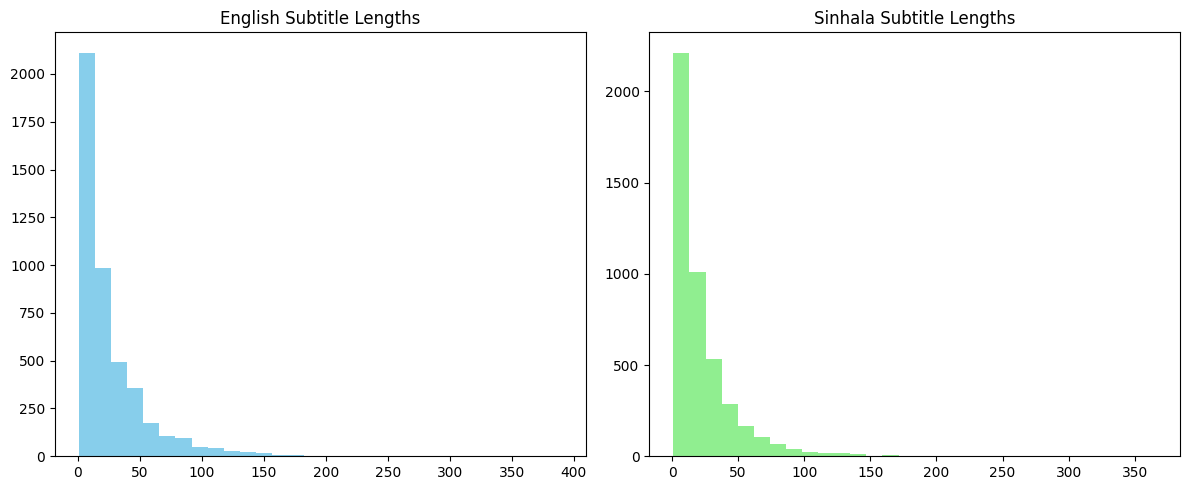

In [41]:
def plot_word_length_histograms(cleaned_data):
    en_lengths = [len(entry['en'].split()) for entry in cleaned_data]
    si_lengths = [len(entry['si'].split()) for entry in cleaned_data]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(en_lengths, bins=30, color='skyblue')
    plt.title("English Subtitle Lengths")

    plt.subplot(1, 2, 2)
    plt.hist(si_lengths, bins=30, color='lightgreen')
    plt.title("Sinhala Subtitle Lengths")

    plt.tight_layout()
    plt.show()

plot_word_length_histograms(aligned_data)

In [42]:
print(f"🔢 Total subtitle pairs: {len(aligned_data)}")

🔢 Total subtitle pairs: 4511
